In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon

In [3]:
from generate_data import RandomDataGenerator

rdg = RandomDataGenerator()

data_range_min = 100
data_range_max = 1000000
range_col_min  = 2
range_col_max  = 20

# Obtenir la liste des nombres de données et de catégories
data_list, col_list = rdg.number_data(data_range_min, data_range_max, range_col_min, range_col_max)

dfs = []
for n_data in data_list:
    for n_categories in col_list:
        df_ref, df_new = rdg.get_data(n_data, n_categories)
        df_name = str(n_data) + "_data_&_" + str(n_categories) + "_cat"
        dfs.append({'Stats': df_name, 'Data':(df_ref, df_new)})
print(f"Nombre de dataframes générés : {len(dfs)}")


Nombre de dataframes générés : 15


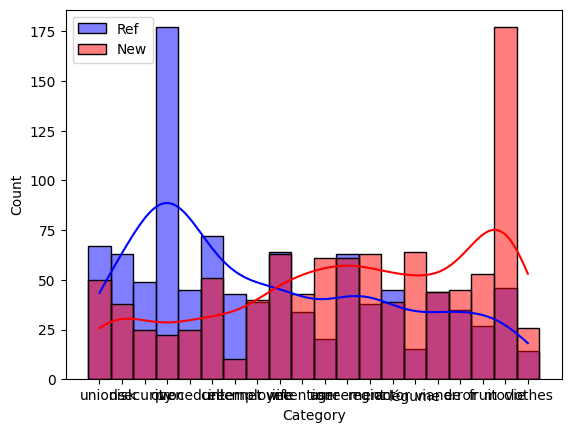

In [4]:
exemple_ref = dfs[5]['Data'][0]
exemple_new = dfs[5]['Data'][1]

# Tracer l'histogramme de chaque colonne des deux dataframes
sns.histplot(exemple_ref['Category'], color="blue", multiple="stack", kde=True, label='Ref')
sns.histplot(exemple_new['Category'], color="red", multiple="stack", kde=True, label='New')

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.show()

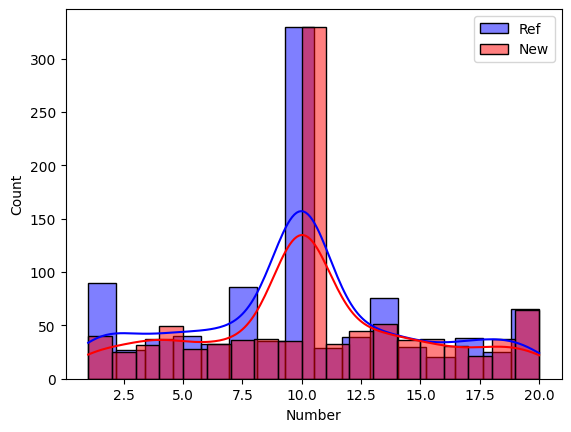

In [5]:
# Tracer l'histogramme de chaque colonne des deux dataframes
sns.histplot(exemple_ref['Number'], color="blue", multiple="stack", kde=True, label='Ref')
sns.histplot(exemple_new['Number'], color="red", multiple="stack", kde=True, label='New')

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.show()

In [6]:
def get_proba(column1, column2):
    distribution_1 = Counter(column1)
    distribution_2 = Counter(column2)

    ensemble_categories = set(list(distribution_1.keys()) + list(distribution_2.keys()))

    probabilites_1 = np.array([distribution_1.get(cat, 0) / float(sum(distribution_1.values())) for cat in ensemble_categories])
    probabilites_2 = np.array([distribution_2.get(cat, 0) / float(sum(distribution_2.values())) for cat in ensemble_categories])
    
    return [probabilites_1, probabilites_2]

def check_drift(wd_prob):
    if wd_prob > 0.1:
        drift_ws_prob = True
    else:
        drift_ws_prob = False
        
    return drift_ws_prob

In [7]:
benchmark_prob = []

for df in dfs:    
    df_ref = df['Data'][0]
    df_new = df['Data'][1]
    
    for column in df_new.columns:
        probs       = get_proba(df_ref[column], df_new[column])
        drift_probs = jensenshannon(probs[0], probs[1])
        is_drift    = check_drift(drift_probs)
        
        if(df_new[column].dtype == np.float64 or df_new[column].dtype == np.int64):
            category    = "numeric"
        else:
            category    = "category"

        benchmark_prob.append({'Df': df['Stats'], 'column': column, 'type': category, 'js': round(drift_probs, 3), 'drift_js': is_drift})

benchmark_df_pob = pd.DataFrame(benchmark_prob)

In [8]:
benchmark_df_pob

,Df,column,type,js,drift_js
0,100_data_&_2_cat,Category,category,0.325,True
1,100_data_&_2_cat,Number,numeric,0.205,True
2,100_data_&_10_cat,Category,category,0.359,True
3,100_data_&_10_cat,Number,numeric,0.247,True
4,100_data_&_20_cat,Category,category,0.407,True
5,100_data_&_20_cat,Number,numeric,0.311,True
6,1000_data_&_2_cat,Category,category,0.615,True
7,1000_data_&_2_cat,Number,numeric,0.066,False
8,1000_data_&_10_cat,Category,category,0.420,True
9,1000_data_&_10_cat,Number,numeric,0.072,False


le bon

adwin

In [154]:
test_ref = dfs[14]['Data'][0]
test_new = dfs[14]['Data'][1]

# Division en 4 parties égales
df_list_ref = np.array_split(test_ref, 1000)
df_list_new = np.array_split(test_new, 1000)

for test in df_list_ref[750:1000]:
    df_list_new.append(test)



for test in df_list_ref[500:750]:
    df_list_new.insert(0, test)

del df_list_ref[500:1000]
df_list_ref = pd.concat(df_list_ref)
# df_list_new.insert(0, df_new_bg)

In [155]:
js_time_cat = []
js_time_num = []

for batch in df_list_new:
    for column in batch.columns:
        
        probs       = get_proba(df_list_ref[column], batch[column])
        drift_probs = jensenshannon(probs[0], probs[1])
        
        if(batch[column].dtype == np.float64 or batch[column].dtype == np.int64):
            js_time_num.append(drift_probs)
        else:
            js_time_cat.append(drift_probs)
        

js_time_cat_df = pd.DataFrame(js_time_cat)
js_time_num_df = pd.DataFrame(js_time_num)

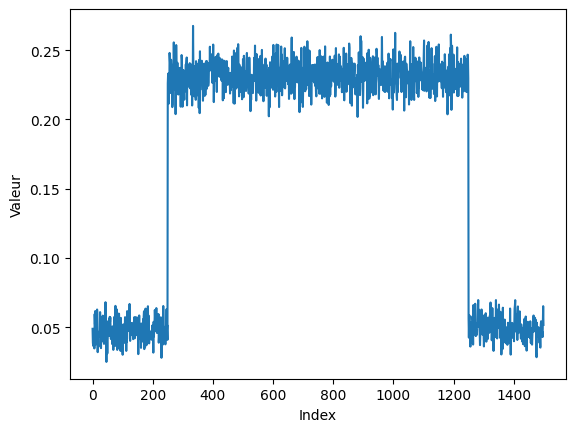

In [157]:
# Tracer un graphe de points en fonction de l'index
plt.plot(js_time_cat_df.index, js_time_cat_df)

# Ajouter une légende pour les axes
plt.xlabel('Index')
plt.ylabel('Valeur')

# Afficher le graphe
plt.show()

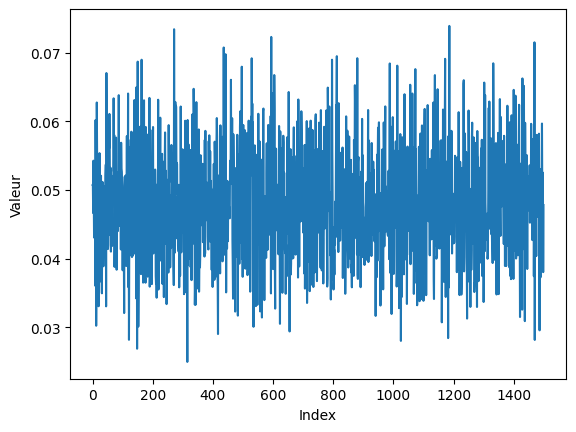

In [158]:
# Tracer un graphe de points en fonction de l'index
plt.plot(js_time_num_df.index, js_time_num_df)

# Ajouter une légende pour les axes
plt.xlabel('Index')
plt.ylabel('Valeur')

# Afficher le graphe
plt.show()

In [159]:
from river import drift

adwin = drift.ADWIN()

for i, val in enumerate(js_time_cat_df.iterrows()):
    index, data = val
    _ = adwin.update(data[0])
    if adwin.drift_detected:
        print(f"Change detected at index {i}, input value: {val}")

Change detected at index 383, input value: (383, 0    0.236393
Name: 383, dtype: float64)
Change detected at index 1343, input value: (1343, 0    0.0506
Name: 1343, dtype: float64)


moyenne

découper la ref en plein de morceau

In [188]:
ref = dfs[14]['Data'][0]

col_cat = ref.loc[:, 'Category']
col_num = ref.loc[:, 'Number']


# Division en 4 parties égales
list_cat_moy = np.array_split(col_cat, 1000)
list_num_moy = np.array_split(col_num, 1000)

In [176]:
import random

# Créer une liste de tous les nombres de 1 à 100
liste_1_a_100 = list(range(0, 999))

# Créer une liste de toutes les combinaisons uniques de deux chiffres aléatoires
liste_combinaisons = [(a, b) for a in random.sample(liste_1_a_100, 100) for b in random.sample(liste_1_a_100, 100) if a != b]

In [201]:
avg_js_cat = []
avg_js_num = []


for batch in liste_combinaisons:
    probs_cat       = get_proba(list_cat_moy[batch[0]], list_cat_moy[batch[1]])
    probs_num       = get_proba(list_num_moy[batch[0]], list_num_moy[batch[1]])
    drift_probs_cat = jensenshannon(probs_cat[0], probs_cat[1])
    drift_probs_num = jensenshannon(probs_num[0], probs_num[1])
    avg_js_cat.append(drift_probs_cat)
    avg_js_num.append(drift_probs_num)

In [204]:
moyenne_cat = np.mean(avg_js_cat)
moyenne_num = np.mean(avg_js_num)

print(moyenne_cat, moyenne_num)

0.06870463655001623 0.067529792526721
